## Cell cycle scoring vignette testing score_genes

In [62]:
import scanpy as sc
import pytest
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()
sc.logging.print_version_and_date()

-----
anndata     0.10.8
scanpy      1.10.2
-----
PIL                 9.0.1
apport_python_hook  NA
backcall            0.2.0
cairo               1.20.1
cffi                1.16.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.8.2
decorator           4.4.2
defusedxml          0.7.1
entrypoints         0.4
exceptiongroup      1.2.1
h5py                3.11.0
igraph              0.11.6
iniconfig           NA
ipykernel           6.7.0
ipython_genutils    0.2.0
ipywidgets          6.0.0
jedi                0.18.0
joblib              1.4.2
kiwisolver          1.3.2
legacy_api_wrap     NA
llvmlite            0.43.0
louvain             0.8.2
lz4                 3.1.3+dfsg
matplotlib          3.9.1
matplotlib_inline   NA
mpl_toolkits        NA
natsort             8.4.0
netifaces           0.11.0
numba               0.60.0
numpy               1.26.4
packaging           21.3
pandas              2.2.2
parso         

In [63]:
adata = sc.read_csv('.../cell_cycle_vignette_files/nestorawa_forcellcycle_expressionMatrix.txt', delimiter='\t').T

In [64]:
cell_cycle_genes = [x.strip() for x in open('.../cell_cycle_vignette_files/regev_lab_cell_cycle_genes.txt')]

In [65]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

In [66]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

filtered out 443 genes that are detected in less than 3 cells
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [67]:
sc.pp.scale(adata)

In [68]:
"""Calculate scores based on the expression of gene lists."""
from __future__ import annotations

from typing import TYPE_CHECKING

import numpy as np
import pandas as pd
from scipy.sparse import issparse

from scanpy._utils import _check_use_raw, is_backed_type

import logging as logg
#from .._compat import old_positionals
#rom ..get import _get_obs_rep

if TYPE_CHECKING:
    from collections.abc import Sequence
    from typing import Literal

    from anndata import AnnData
    from numpy.typing import DTypeLike, NDArray
    from scipy.sparse import csc_matrix, csr_matrix

    #from .._utils import AnyRandom

def _sparse_nanmean(
    X: csr_matrix | csc_matrix, axis: Literal[0, 1]
) -> NDArray[np.float64]:
    
    if not issparse(X):
        raise TypeError("X must be a sparse matrix")

    # count the number of nan elements per row/column (dep. on axis)
    Z = X.copy()
    Z.data = np.isnan(Z.data)
    Z.eliminate_zeros()
    n_elements = Z.shape[axis] - Z.sum(axis)

    # set the nans to 0, so that a normal .sum() works
    Y = X.copy()
    Y.data[np.isnan(Y.data)] = 0
    Y.eliminate_zeros()

    # the average
    s = Y.sum(axis, dtype="float64")  # float64 for score_genes function compatibility)
    m = s / n_elements

    return m

def score_genes(
    adata: AnnData,
    gene_list: Sequence[str] | pd.Index[str],
    *,
    ctrl_as_ref: bool = True,
    ctrl_size: int = 50,
    gene_pool: Sequence[str] | pd.Index[str] | None = None,
    n_bins: int = 25,
    score_name: str = "score",
    random_state: AnyRandom = 0,
    copy: bool = False,
    use_raw: bool | None = None,
    layer: str | None = None,
) -> AnnData | None:
    """\
    Score a set of genes :cite:p:`Satija2015`.

    The score is the average expression of a set of genes subtracted with the
    average expression of a reference set of genes. The reference set is
    randomly sampled from the `gene_pool` for each binned expression value.

    This reproduces the approach in Seurat :cite:p:`Satija2015` and has been implemented
    for Scanpy by Davide Cittaro.

    Parameters
    ----------
    adata
        The annotated data matrix.
    gene_list
        The list of gene names used for score calculation.
    ctrl_as_ref
        Allow the algorithm to use the control genes as reference.
        Will be changed to `False` in scanpy 2.0.
    ctrl_size
        Number of reference genes to be sampled from each bin. If `len(gene_list)` is not too
        low, you can set `ctrl_size=len(gene_list)`.
    gene_pool
        Genes for sampling the reference set. Default is all genes.
    n_bins
        Number of expression level bins for sampling.
    score_name
        Name of the field to be added in `.obs`.
    random_state
        The random seed for sampling.
    copy
        Copy `adata` or modify it inplace.
    use_raw
        Whether to use `raw` attribute of `adata`. Defaults to `True` if `.raw` is present.

        .. versionchanged:: 1.4.5
           Default value changed from `False` to `None`.
    layer
        Key from `adata.layers` whose value will be used to perform tests on.

    Returns
    -------
    Returns `None` if `copy=False`, else returns an `AnnData` object. Sets the following field:

    `adata.obs[score_name]` : :class:`numpy.ndarray` (dtype `float`)
        Scores of each cell.

    Examples
    --------
    See this `notebook <https://github.com/scverse/scanpy_usage/tree/master/180209_cell_cycle>`__.
    """
    start = logg.info(f"computing score {score_name!r}")
    adata = adata.copy() if copy else adata
    use_raw = _check_use_raw(adata, use_raw)
    if is_backed_type(adata.X) and not use_raw:
        raise NotImplementedError(
            f"score_genes is not implemented for matrices of type {type(adata.X)}"
        )

    if random_state is not None:
        np.random.seed(random_state)

    var_names = adata.raw.var_names if use_raw else adata.var_names
    gene_list = pd.Index([gene_list] if isinstance(gene_list, str) else gene_list)
    genes_to_ignore = gene_list.difference(var_names, sort=False)  # first get missing
    gene_list = gene_list.intersection(var_names)  # then restrict to present
    if len(genes_to_ignore) > 0:
        logg.warning(f"genes are not in var_names and ignored: {genes_to_ignore}")
    if len(gene_list) == 0:
        raise ValueError("No valid genes were passed for scoring.")

    if gene_pool is None:
        gene_pool = var_names.astype("string")
    else:
        gene_pool = pd.Index(gene_pool, dtype="string").intersection(var_names)
    if len(gene_pool) == 0:
        raise ValueError("No valid genes were passed for reference set.")

    # Trying here to match the Seurat approach in scoring cells.
    # Basically we need to compare genes against random genes in a matched
    # interval of expression.

    def get_subset(genes: pd.Index[str]):
        x = adata.X
        if len(genes) == len(var_names):
            return x
        idx = var_names.get_indexer(genes)
        return x[:, idx]

    # average expression of genes
    obs_avg = pd.Series(_nan_means(get_subset(gene_pool), axis=0), index=gene_pool)
    # Sometimes (and I don’t know how) missing data may be there, with NaNs for missing entries
    obs_avg = obs_avg[np.isfinite(obs_avg)]

    n_items = int(np.round(len(obs_avg) / (n_bins - 1)))
    obs_cut = obs_avg.rank(method="min") // n_items
    #obs_avg.sort_values(ascending=True, inplace=True)
    #n_items = int(np.ceil(len(obs_avg) / (n_bins)))
    #rank = np.repeat(np.arange(n_bins), n_items)[:len(obs_avg)]
    #obs_cut = pd.Series(rank, index=obs_avg.index)
 
    keep_ctrl_in_obs_cut = False if ctrl_as_ref else obs_cut.index.isin(gene_list)

    # now pick `ctrl_size` genes from every cut
    control_genes = pd.Index([], dtype="string")
    for cut in np.unique(obs_cut.loc[gene_list]):
        r_genes: pd.Index[str] = obs_cut[(obs_cut == cut) & ~keep_ctrl_in_obs_cut].index
        if len(r_genes) == 0:
            msg = (
                f"No control genes for {cut=}. You might want to increase "
                f"gene_pool size (current size: {len(gene_pool)})"
            )
            logg.warning(msg)
        if ctrl_size < len(r_genes):
            r_genes = r_genes.to_series().sample(ctrl_size).index
        if ctrl_as_ref:  # otherwise `r_genes` is already filtered
            r_genes = r_genes.difference(gene_list)
        control_genes = control_genes.union(r_genes)

    if len(control_genes) == 0:
        msg = "No control genes found in any cut."
        if ctrl_as_ref:
            msg += " Try setting `ctrl_as_ref=False`."
        raise RuntimeError(msg)

    means_list, means_control = (
        _nan_means(get_subset(genes), axis=1, dtype="float64")
        for genes in (gene_list, control_genes)
    )
    score = means_list - means_control

    adata.obs[score_name] = pd.Series(
        np.array(score).ravel(), index=adata.obs_names, dtype="float64"
    )
    
    # get some diagnostics for plotting
    cut_list = []
    n_list = []
    mean_list = []
    sd_list = []
    for i in range(25):
        genes = obs_cut[obs_cut == i].index
        cut_list.append(i)
        n_list.append(len(genes))
        mean_list.append(np.nanmean(np.nanmean(get_subset(genes), axis=1, dtype="float64")))
        sd_list.append(np.nanstd(np.nanmean(get_subset(genes), axis=1, dtype="float64")))
    return cut_list, n_list, mean_list, sd_list, means_list, means_control, score

    

    logg.info(
        "    finished",
        time=start,
        deep=(
            "added\n"
            f"    {score_name!r}, score of gene set (adata.obs).\n"
            f"    {len(control_genes)} total control genes are used."
        ),
    )
    return adata if copy else None


def _nan_means(
    x, *, axis: Literal[0, 1], dtype: DTypeLike | None = None
) -> NDArray[np.float64]:
    if issparse(x):
        return np.array(_sparse_nanmean(x, axis=axis)).flatten()
    return np.nanmean(x, axis=axis, dtype=dtype)



/tmp/ipykernel_490533/1947505961.py:208: RuntimeWarning: Mean of empty slice
  mean_list.append(np.nanmean(np.nanmean(get_subset(genes), axis=1, dtype="float64")))
/tmp/ipykernel_490533/1947505961.py:209: RuntimeWarning: Mean of empty slice
  sd_list.append(np.nanstd(np.nanmean(get_subset(genes), axis=1, dtype="float64")))
/home/mckinnonlab/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, 'Mean expression value in each bin')

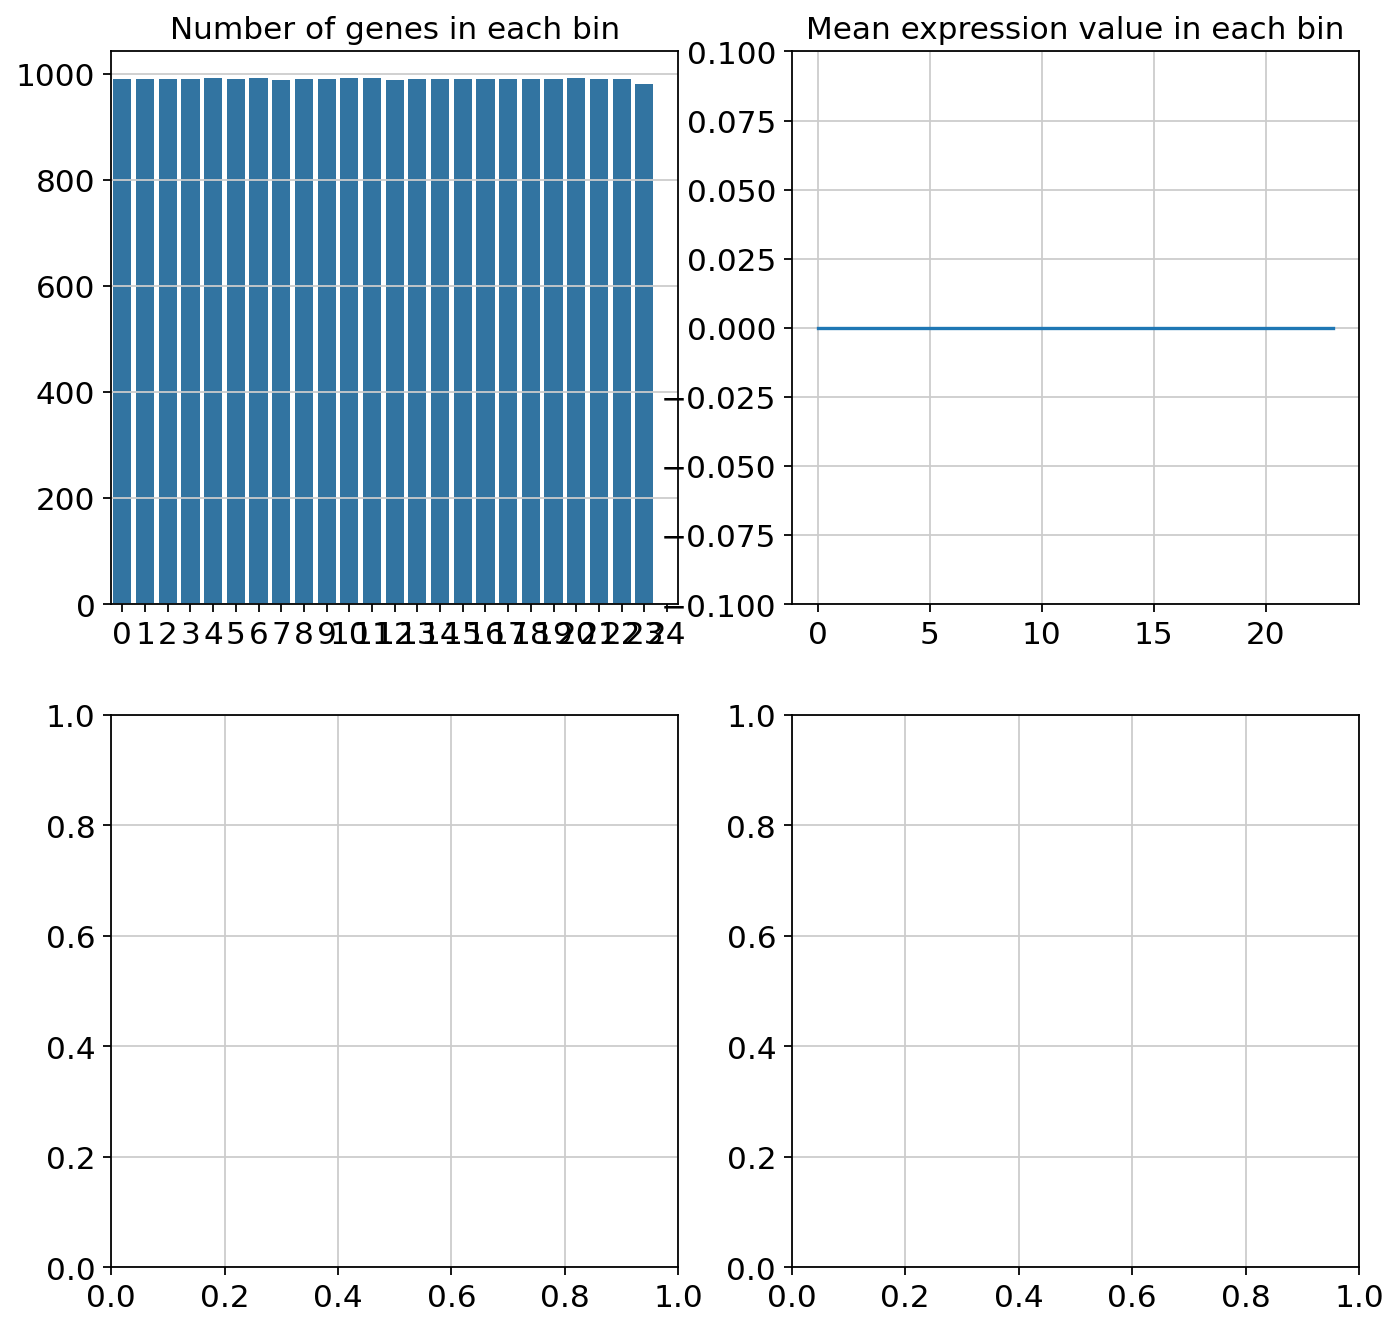

In [69]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
cut_list, n_list, mean_list, sd_list, means_list, means_control, score = score_genes(adata, s_genes, random_state = 0)

rcParams['figure.figsize'] = 10, 10
fig, axs = plt.subplots(2, 2)
sb.barplot(x=cut_list, y=n_list, ax=axs[0, 0])
axs[0, 0].set_title('Number of genes in each bin')
sb.lineplot( x=cut_list, y=mean_list, ax=axs[0, 1])
axs[0, 1].set_ylim(-.1, .1)
axs[0, 1].set_title('Mean expression value in each bin')

In [70]:
list(n_list)

[990,
 989,
 990,
 990,
 991,
 989,
 992,
 988,
 990,
 990,
 991,
 992,
 987,
 990,
 990,
 990,
 990,
 990,
 990,
 990,
 991,
 990,
 989,
 981,
 0]